In [4]:
%pylab inline
import torch
from torch.autograd import Variable
from torch import nn
import loader
from qLearningNet import *
import time
from AIModels import *
from replayMemory import *
from g2048 import *
import os


LEARNING_RATES_TO_TRY = np.logspace(-4.0,4.0,6)

EPOCHS = 10000

MOVES = [0, 1, 2, 3]

FILENAME = "saved_parameters"
INPUT_SIZE = 16
HIDDEN_SIZE = 256

PLAYED_GAME = G2048

DATA_HOLDER_PREFIX = "resultminmax"

def testNet(filename=None, net=None):
    game = PLAYED_GAME(save_game=False)
    if filename is not None:
        ai = QLearningNetAI(game, filename=filename)
    elif net is not None:
        ai = QLearningNetAI(game, net=net)
    scores, move_count, highs = AIModel.test_ai(ai, 400, verbose=False)
    return move_count, np.mean(scores), np.mean(highs)

def plot_result(path, title):
    scores = np.loadtxt(path+'scores')
    q_values = np.loadtxt(path+'qvalues')
    loses = np.loadtxt(path+'loses')
    figure(figsize=(16,10))
    subplot(1,3,1)
    plot(range(100,len(scores)*100+1, 100), scores, marker='o')
    xlabel('Number of epochs')
    ylabel('Average score')
    subplot(1,3,2)
    plot(range(100,len(scores)*100+1, 100), np.log(loses), marker='o')
    xlabel('Number of epochs')
    ylabel('Loss')
    subplot(1,3,3)
    plot(range(100,len(scores)*100+1, 100), q_values, marker='o')
    xlabel('Number of epochs')
    ylabel('Q values')
    show()

test_q_set = loader.Loader.get_random_states(PLAYED_GAME(), 100, input_size=INPUT_SIZE)

Populating the interactive namespace from numpy and matplotlib


In [5]:
def train(model, data_loaders, optimizer, num_epochs=500, log_every=100, verbose=True, batch_size=100, \
          use_memory=True, gamma=0.8, filename_prefix=""):
    replays = ReplayMemory(10**5, entry_len=34)
        
    results = []
    losses = []
    q_values = []
    
    epoch = 0
    if verbose:
        print u'Training the model!'
        print u'Interrupt at any time to get current model'
    try:
        while epoch < num_epochs:
            epoch += 1
            new_data = data_loaders.get(model, batch_size)
            if use_memory:
                replays.add(new_data)
                x = replays.choose(batch_size)
            else:
                x = new_data
            
            future = x[:, (INPUT_SIZE+2):]
            future_scores = model.Q(future)
            for i, row in enumerate(future):
                game = PLAYED_GAME(save_game=False, data=row.tolist())
                for j, move in enumerate(MoveEnum):
                    if not game.canMove(move):
                        future_scores[i, j] = float('-inf')
                if not game.getPossibleMoves():
                    future_scores[i:,:] = np.full((1,4), x[i, (INPUT_SIZE+1)])
                
            y = x[:, (INPUT_SIZE+1)] + gamma * np.max(future_scores, axis=1)
            xx = x[:, :INPUT_SIZE]

            optimizer.zero_grad()
            i = np.asarray(np.vstack((np.arange(0,batch_size),x[:,INPUT_SIZE])),int)
            
            i = torch.LongTensor(i)
            out = model.Q(xx, as_variable=True)[i[0],i[1]]
            loss = model.loss(out, y)
            loss.backward()
            optimizer.step()

            if epoch % log_every == 0 and verbose:
                print u"Minibatch {0: >6}  | loss {1: >15.12f} ".format(epoch, loss.data[0])
                result = testNet(net=model)
                print u"The average score was {}".format(result[1])
                results += [result[1]]
                losses += [loss.data.numpy()]
                q_val = model.Q(test_q_set)
                q_values += [np.mean(np.max(q_val, axis=1))]
                print u"The average Q function value was {}".format(q_values[-1])
                
            if epoch % (log_every * 20) == 0:
                result = testNet(net=model)
                filename = filename_prefix + FILENAME +'{}_{}'.format(epoch, int(result[1]))
                model.save_parameters(filename)
                

    except KeyboardInterrupt:
        pass
    result = testNet(net=model)
    filename = filename_prefix + FILENAME +'{}_{}'.format(epoch, int(result[1]))
    model.save_parameters(filename)
    return results, losses, q_values

In [ ]:
for lr in LEARNING_RATES_TO_TRY:
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    print "Saving to",path
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    q_learning_net = QLearningNet(input_size=INPUT_SIZE)
    for p in q_learning_net.network.parameters():
        p.requires_grad = True
    optimizer = torch.optim.Adam(q_learning_net.network.parameters(), lr=lr)
    data_loader = loader.MinMaxLoader(game=PLAYED_GAME())
    scores, loses, q_values = train(q_learning_net, data_loader, optimizer, num_epochs=EPOCHS,filename_prefix=path)
    print "Learning for",lr,"done. (#learningdone)"
    np.savetxt(path+'scores', scores)
    np.savetxt(path+'loses', loses)
    np.savetxt(path+'qvalues', q_values)

Saving to resultminmax/results_lr_0.00010/
Training the model!
Interrupt at any time to get current model


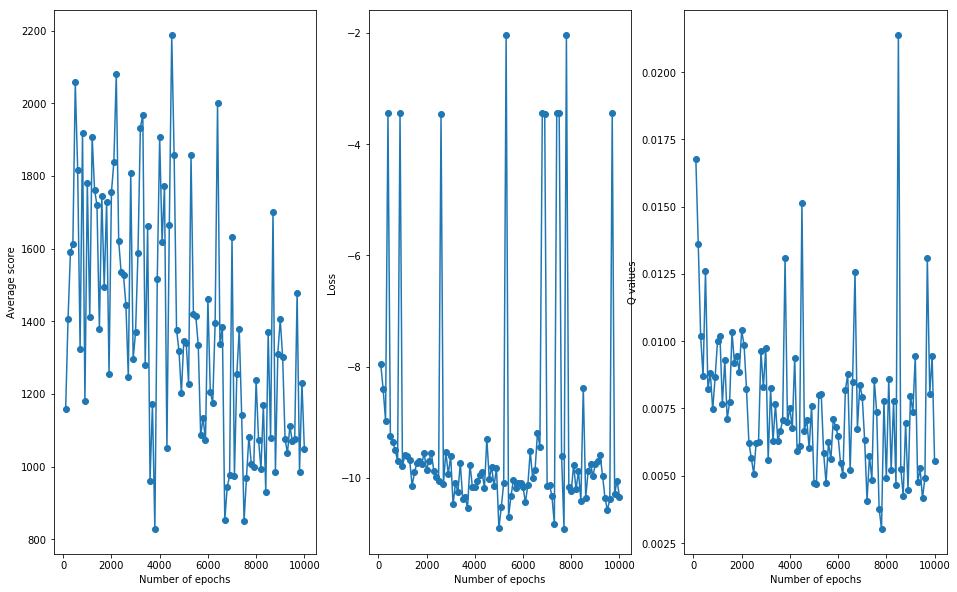

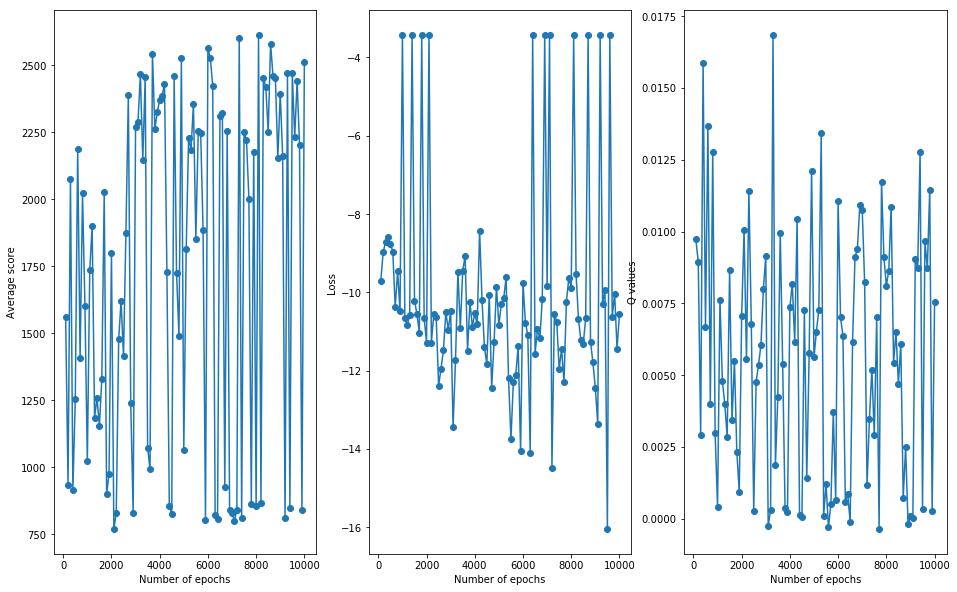

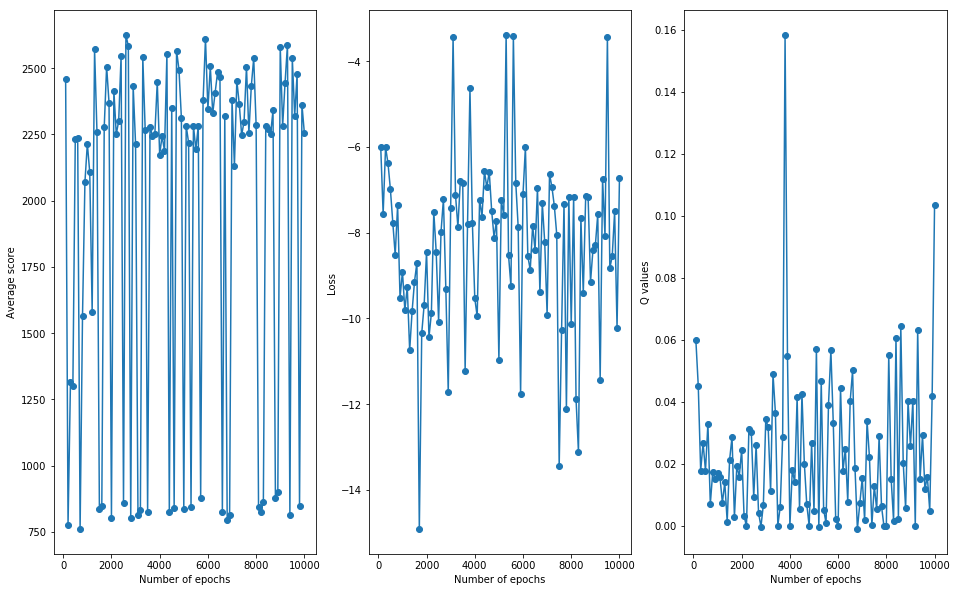

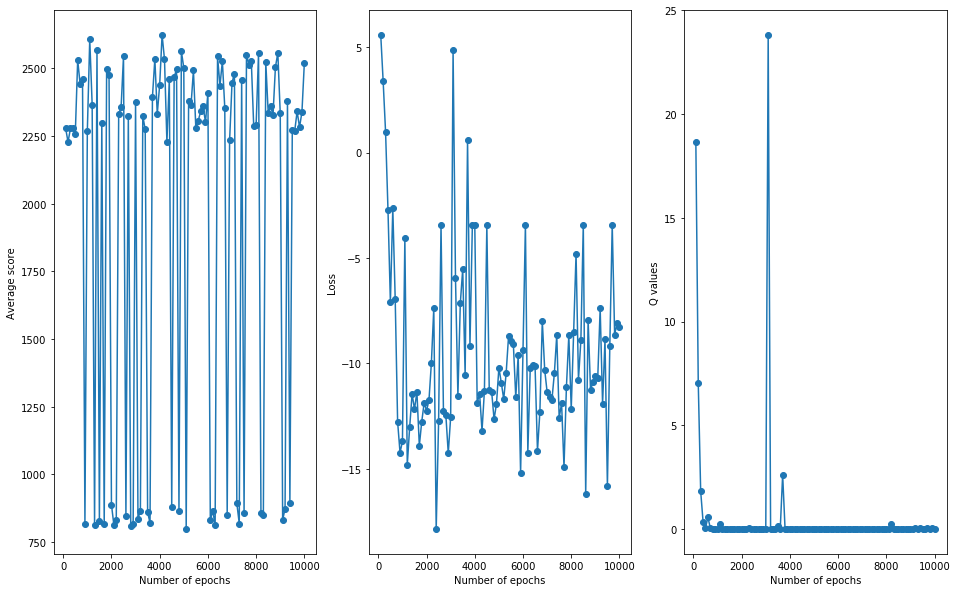

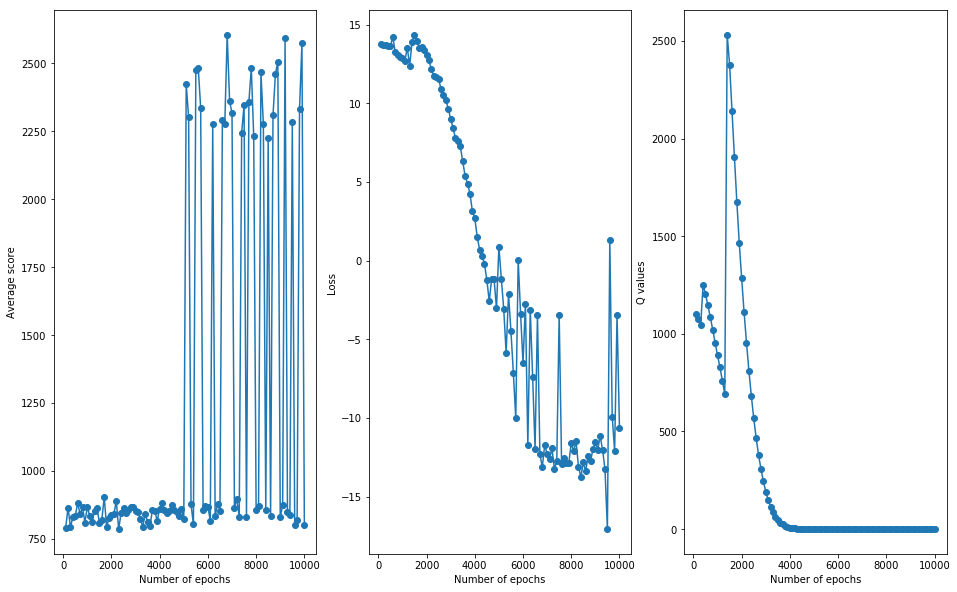

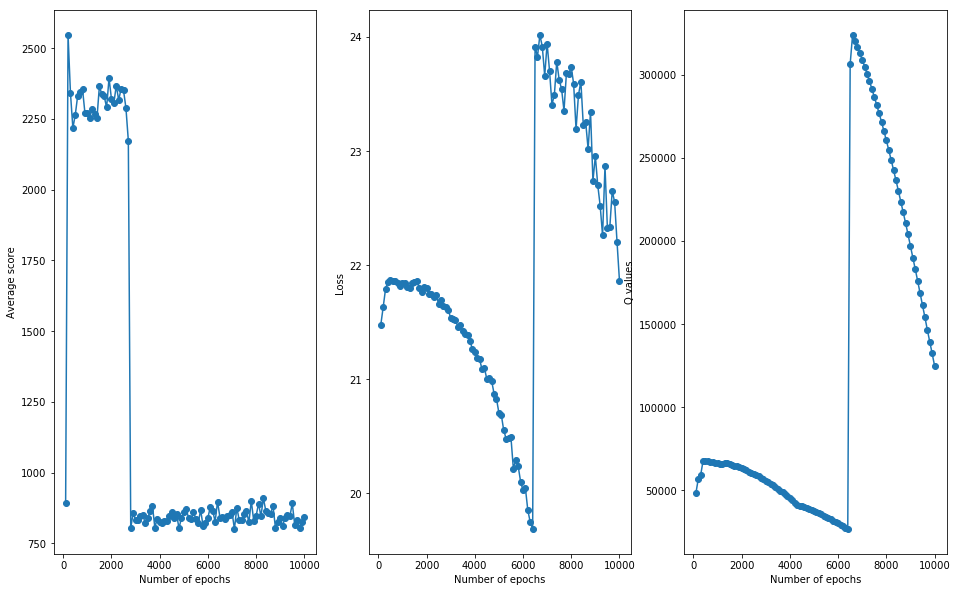

In [5]:
for lr in LEARNING_RATES_TO_TRY:
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    plot_result(path, "MINMAX LR {}".format(lr))

In [24]:
game = PLAYED_GAME(save_game=False)
ai = RandomAI(game)
scores, move_count, highs = AIModel.test_ai(ai, 10, verbose=False)
print move_count
print np.mean(scores), np.mean(highs)

{'Down': 305, 'Right': 310, 'Up': 315, 'Left': 295}
1134.4 105.6
